In [1]:
import keras        

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [2]:
print("Using Keras version",keras.__version__)
%matplotlib inline

Using Keras version 2.3.1


In [3]:
import matplotlib.pyplot as plt

In [4]:
plt.rcParams['figure.dpi'] = 125

In [5]:
from IPython.display import set_matplotlib_formats, display, HTML
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [7]:
import openml as oml

In [8]:
mnist = oml.datasets.get_dataset(554)

In [9]:
X,Y = mnist.get_data(target=mnist.default_target_attribute)

ValueError: too many values to unpack (expected 2)

In [10]:
from keras.datasets import mnist
from matplotlib import pyplot
# Load Dataset
(trainX,trainY),(testX,testY) = mnist.load_data()
# Summarize Loaded Data Set
print('Train: X=%s , y=%s'%(trainX.shape,trainY.shape))
print('Test: X=%s , y=%s'%(testX.shape,testY.shape))

Train: X=(60000, 28, 28) , y=(60000,)
Test: X=(10000, 28, 28) , y=(10000,)


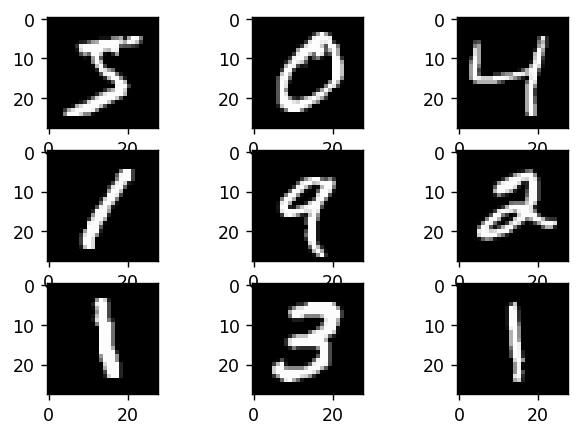

In [11]:
#plot first few images
for i in range(9):
    #define subplot
    pyplot.subplot(330+1+i)
    #plot row pixel data
    pyplot.imshow(trainX[i],cmap=pyplot.get_cmap('gray'))

pyplot.show()

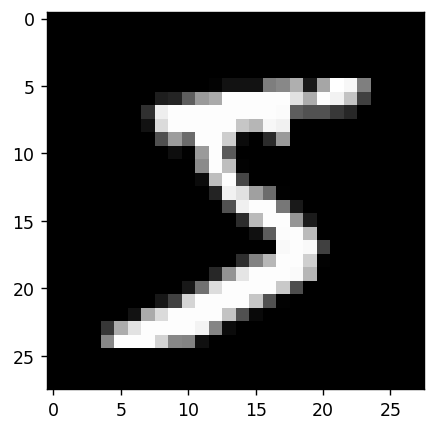

In [12]:
pyplot.imshow(trainX[0],cmap=pyplot.get_cmap('gray'))

pyplot.show()

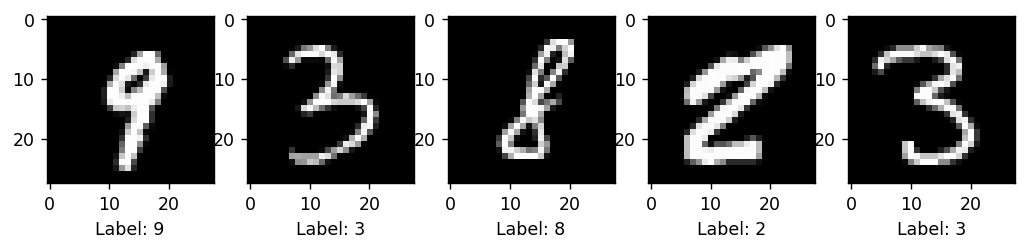

In [13]:
# Take some random examples
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,60000)
    axes[i].imshow(trainX[n], cmap=pyplot.get_cmap('gray'))
    axes[i].set_xlabel("Label: {}".format(trainY[n]))
plt.show();

In [14]:
(trainX, trainY), (testX, testY) = mnist.load_data()

In [15]:
trainX = trainX.reshape((trainX.shape[0],28,28,1))
testX = testX.reshape((testX.shape[0],28,28,1))

In [16]:
trainX.shape

(60000, 28, 28, 1)

In [17]:
from keras.utils import to_categorical
trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [18]:
trainY.shape

(60000, 10)

In [19]:
def load_dataset():
    # load dataset
    (trainX,trainY),(testX,testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0],28,28,1))
    testX = testX.reshape((testX.shape[0],28,28,1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX,trainY,testX,testY

In [20]:
# scale pixels
def prep_pixels(train,test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm/255.0
    test_norm = test_norm/255.0
    # return normalized images
    return train_norm,test_norm
    

In [28]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32,(3,3),activation='relu',kernel_initializer='he_uniform',input_shape=(28,28,1)))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(100,activation='relu',kernel_initializer='he_uniform'))
    model.add(Dense(10,activation='softmax'))
    #compile model
    opt = SGD(lr=0.01,momentum=0.9)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [22]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX,dataY,n_folds=5):
    scores,histories = list(),list()
    # prepare cross validation
    kfold = KFold(n_folds,shuffle=True,random_state=1)
    #enumerate splits
    for train_ix , test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX,trainY,testX,testY = dataX[train_ix],dataY[train_ix],dataX[test_ix],dataY[test_ix]
        # fit model
        history = model.fit(trainX,trainY,epochs=10,batch_size=32,validation_data=(testX,testY),verbose=0)
        # evaluate model
        _ , acc = model.evaluate(testX,testY,verbose=0)
        print('> %.3f' %(acc*100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores,histories

In [30]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        #plot loss
        pyplot.subplot(2,1,1)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'],color='blue',label='train')
        pyplot.plot(histories[i].history['val_loss'],color='orange',label='test')
        # plot accuracy
        pyplot.subplot(2,1,2)
        pyplot.title('Classification Loss')
        pyplot.plot(histories[i].history['accuracy'],color='blue',label='train')
        pyplot.plot(histories[i].history['val_accuracy'],color='orange',label='test')
    pyplot.show()

In [24]:
# Summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f,n=%d' %(mean(scores)*1008,std(scores)*100,len(scores)))
    # box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()
    

In [25]:
# run the test narness for evaluating a model
def run_test_harness():
    # load dataset
    trainX,trainY,testX,testY = load_dataset()
    # prepare pixel data
    trainX,testX = prep_pixels(trainX,testX)
    # evaluate model
    scores,histories = evaluate_model(trainX,trainY)
    #learning curves
    summarize_diagnostics(histories)
    #summarize estimated performance
    summarize_performance(scores)

> 98.433
> 98.675
> 98.567
> 98.817
> 98.750


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a prev

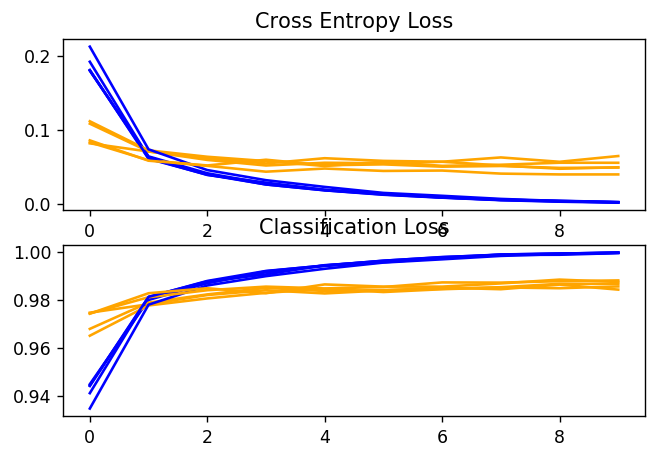

Accuracy: mean=994.375 std=0.136,n=5


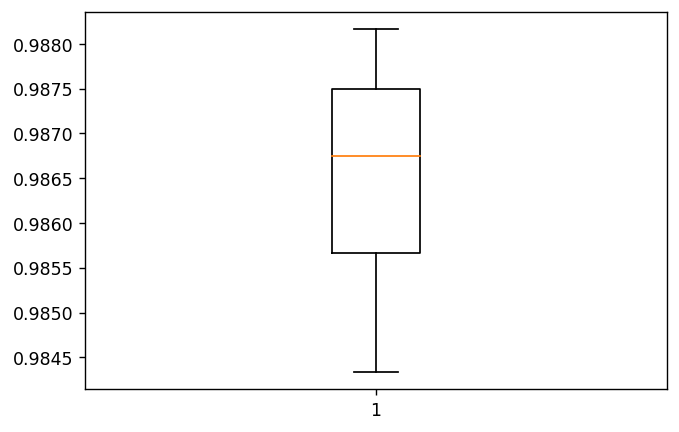

In [32]:
# deeper cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
# entry point, run the test harness
run_test_harness()

In [31]:
summarize_diagnostics(histories)
    #summarize estimated performance
summarize_performance(scores)

NameError: name 'histories' is not defined